In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [35]:
%%R
library(dplyr)
library(scales)
library(grid)
library(ggplot2)
library(gridExtra)
library(magrittr)
library(readr)
library(ggsignif)
require('userfriendlyscience')
library(FSA)

In [7]:
%%R
qPCR = read_csv("data/AfaDVload.csv")

qPCR = tbl_df(qPCR)

glimpse(qPCR)

Observations: 219
Variables: 22
$ SampleName         <chr> "SML42", "OGL2", "MYA49", "SML214", "SML08", "MY...
$ Species            <chr> "Asterias vulgaris", "Asterias forbesi", "Asteri...
$ CommonName         <chr> "Northern Star", "Forbes Star", "Forbes Star", "...
$ CollectionLocation <chr> "SML", "MA", "SC", "SML", "SML", "SC", "MA", "SC...
$ CollectionYear     <int> 2016, 2016, 2012, 2016, 2016, 2013, 2016, 2012, ...
$ Health             <chr> "Aymptomatic", "Aymptomatic", "Symptomatic", "Ay...
$ AnimalSize         <dbl> 6.2, 6.0, NA, 7.0, 7.0, NA, 6.5, NA, 5.5, NA, 8....
$ SampleType         <chr> "E", "G", "G", "E", "E", "G", "G", "E", "E", "PC...
$ SampleAmount       <chr> "66.5 mg", "77.6 mg", "75.5 mg", "82.5 mg", "72....
$ Elution            <chr> "30 ul", "30 ul", "30 ul", "30 ul", "30 ul", "30...
$ eff%               <dbl> 71.804, 84.295, 132.787, 79.865, 71.804, 132.787...
$ R2 standards       <dbl> 0.960, 0.971, 0.984, 0.956, 0.960, 0.984, 0.983,...
$ run#              

## Kruskal Wallis Test

In [14]:
%%R
qPCRsummary4 = qPCR %>%
 filter(SampleType %in% c("G","PC","E")) %>%
 group_by(SampleType) %>%
 summarise(avg = mean(cal_viralload), sd = sd(cal_viralload), sem = sd(cal_viralload)/sqrt(length(cal_viralload))) %>%
 arrange(desc(avg))

qPCRsummary4

# A tibble: 3 × 4
  SampleType        avg         sd        sem
      <fctr>      <dbl>      <dbl>      <dbl>
1         PC 15964.0184 32105.1018 3422.41536
2          E  1756.9400  7198.6245  842.53527
3          G   442.0054   548.6527   87.85474


In [16]:
%%R
qPCR$SampleType = as.factor(qPCR$SampleType)

In [15]:
%%R
kruskal = kruskal.test(cal_viralload ~ SampleType, data=qPCR)

kruskal


	Kruskal-Wallis rank sum test

data:  cal_viralload by SampleType
Kruskal-Wallis chi-squared = 41.392, df = 2, p-value = 1.027e-09



In [ ]:
%%R
pairwise.wilcox.test(dfsha$Shannon, dfsha$SampleType,p.adjust.method="bonf")

#### Dunnett Test Post Hoc

In [559]:
%%R

Dunn = dunnTest(cal_viralload ~ SampleType, data=qPCR, method="bh")

Dunn

  Comparison         Z      P.unadj        P.adj
1      E - G  1.560677 1.185999e-01 1.185999e-01
2     E - PC -4.935373 7.999769e-07 1.199965e-06
3     G - PC -5.670808 1.421253e-08 4.263758e-08


## Welch's ANOVA followed by Games-Howell on Log10 values

In [536]:
%%R
qPCRsummary = qPCR %>%
 group_by(SampleType) %>%
 filter(SampleType %in% c("G","PC","E")) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

qPCRsummary

# A tibble: 3 × 4
  SampleType      avg        sd        sem
       <chr>    <dbl>     <dbl>      <dbl>
1         PC 3.313068 0.9367115 0.09985378
2          E 2.561918 0.6654315 0.07788286
3          G 2.338974 0.5277998 0.08451560


#### ANOVA

In [517]:
%%R 
qPCR.log.aov = aov(Log~SampleType,data=qPCR,var.equal=FALSE)
summary(qPCR.log.aov)

             Df Sum Sq Mean Sq F value   Pr(>F)    
SampleType    2  35.11  17.556   29.11 8.38e-12 ***
Residuals   197 118.80   0.603                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
19 observations deleted due to missingness


#### Normal Distribution of data but unequal variance

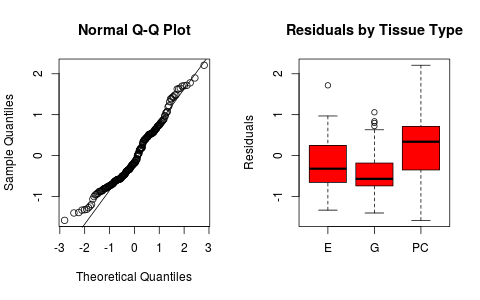

In [512]:
%%R -h 300
par(mfrow=c(1,2))

q = qqnorm(resid(qPCR.log.aov),cex=1.2)
qqline(resid(qPCR.log.aov))

p = boxplot(split(resid(qPCR.log.aov),qPCR$SampleType),ylab="Residuals",col=2)
title("Residuals by Tissue Type")

#### Welch ANOVA

In [535]:
%%R
qPCR.log2.aov = oneway.test(Log~SampleType,data=qPCR,var.equal=FALSE)
qPCR.log2.aov


	One-way analysis of means (not assuming equal variances)

data:  Log and SampleType
F = 29.205, num df = 2.00, denom df = 117.66, p-value = 5.028e-11



#### Games-Howell Post Hoc

In [386]:
%%R

#def function: Games-Howell post hoc

posthoc.tgh <- function(y, x, method=c("games-howell", "tukey"), digits=2) {
  ### Based on http://www.psych.yorku.ca/cribbie/6130/games_howell.R
  method <- tolower(method);
  tryCatch(method <- match.arg(method), error=function(err) {
    stop("Argument for 'method' not valid!");
  });

  res <- list(input = list(x=x, y=y, method=method, digits=digits));

  res$intermediate <- list(x = factor(x[complete.cases(x,y)]),
                               y = y[complete.cases(x,y)]);
      res$intermediate$n <- tapply(y, x, length);
      res$intermediate$groups <- length(res$intermediate$n);
      res$intermediate$df <- sum(res$intermediate$n) - res$intermediate$groups;
      res$intermediate$means <- tapply(y, x, mean);
      res$intermediate$variances <- tapply(y, x, var);

  res$intermediate$pairNames <- combn(levels(res$intermediate$x),
                                      2, paste0, collapse=":");

  res$intermediate$descriptives <- cbind(res$intermediate$n,
                                         res$intermediate$means,
                                         res$intermediate$variances);
  rownames(res$intermediate$descriptives) <- levels(res$intermediate$x);
  colnames(res$intermediate$descriptives) <- c('n', 'means', 'variances');

  ### Start on Tukey
  res$intermediate$errorVariance <-
    sum((res$intermediate$n-1) * res$intermediate$variances) /
    res$intermediate$df;
  res$intermediate$t <- combn(res$intermediate$groups, 2, function(ij) {
    abs(diff(res$intermediate$means[ij]))/
      sqrt(res$intermediate$errorVariance*sum(1/res$intermediate$n[ij]));
  } );
  res$intermediate$p.tukey <- ptukey(res$intermediate$t*sqrt(2),
                                     res$intermediate$groups,
                                     res$intermediate$df,
                                     lower.tail=FALSE);
    res$output <- list();
      res$output$tukey <- cbind(res$intermediate$t,
                                res$intermediate$df,
                                res$intermediate$p.tukey)                                     
      rownames(res$output$tukey) <- res$intermediate$pairNames;
      colnames(res$output$tukey) <- c('t', 'df', 'p');

  ### Start on Games-Howell
  res$intermediate$df.corrected <- combn(res$intermediate$groups, 2, function(ij) {               
    sum(res$intermediate$variances[ij] /
          res$intermediate$n[ij])^2 / 
      sum((res$intermediate$variances[ij] /
             res$intermediate$n[ij])^2 / 
            (res$intermediate$n[ij]-1));
  } );
  res$intermediate$t.corrected <- combn(res$intermediate$groups, 2, function(ij) {               
    abs(diff(res$intermediate$means[ij]))/
      sqrt(sum(res$intermediate$variances[ij] /
                 res$intermediate$n[ij]));
  } );    
  res$intermediate$p.gameshowell <- ptukey(res$intermediate$t.corrected*sqrt(2),
                                           res$intermediate$groups,
                                           res$intermediate$df.corrected,
                                           lower.tail=FALSE)  
  res$output$games.howell <- cbind(res$intermediate$t.corrected,
                                   res$intermediate$df.corrected,
                                   res$intermediate$p.gameshowell);
  rownames(res$output$games.howell) <- res$intermediate$pairNames;
  colnames(res$output$games.howell) <- c('t', 'df', 'p');

  ### Set class and return object
  class(res) <- 'posthocTukeyGamesHowell';
  return(res);

}

print.posthocTukeyGamesHowell <- function(x, digits=x$input$digits, ...) {
  print(x$intermediate$descriptives, digits=digits);
  cat('\n');
  if (x$input$method == 'tukey') {
    print(x$output$tukey);
  }
  else if (x$input$method == 'games-howell') {
    print(x$output$games.howell, digits=digits);
  }
}

posthoc.tgh(y=qPCR$Log, x=qPCR$SampleType);

    n means variances
E  73   2.6      0.44
G  39   2.3      0.28
PC 88   3.3      0.88

       t  df       p
E:G  1.9  94 1.3e-01
E:PC 5.9 156 5.6e-08
G:PC 7.4 118 5.2e-11


### Other Variables

In [366]:
%%R
qPCRsummary2 = qPCR %>%
 group_by(CollectionLocation) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

#limits = aes(ymax = quantity + sem, ymin=quantity - sem)

#p = ggplot(p, aes(Sample_Type,avg)) + geom_bar(stat="identity")# + geom_errorbar()

qPCRsummary2

# A tibble: 4 × 4
  CollectionLocation      avg        sd        sem
               <chr>    <dbl>     <dbl>      <dbl>
1                 MA 3.364483 0.9678540 0.10376484
2                SML 2.662947 0.7167508 0.07353708
3                 SC 2.392432 0.4953192 0.08142998
4               <NA>       NA        NA         NA


In [482]:
%%R
qPCRsummary3 = qPCR %>%
 group_by(Species) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

qPCRsummary3

# A tibble: 3 × 4
            Species      avg        sd        sem
              <chr>    <dbl>     <dbl>      <dbl>
1  Asterias forbesi 3.104958 0.9668285 0.08862903
2          Henricia 2.942903 0.7967818 0.14310624
3 Asterias vulgaris 2.514348 0.6261189 0.07537586


## Plots

#### Load Prevalence Data

In [24]:
%%R
qPCRprev = read.csv("data/AfaDVprev.csv")

qPCRprev

  Tissue.Type Absent Present Total Prevalence  X
1          CF     28       0    28       0.00 NA
2           E     32      73   105       0.70 NA
3           G     30      39    69       0.57 NA
4          PC     14      88   102       0.86 NA


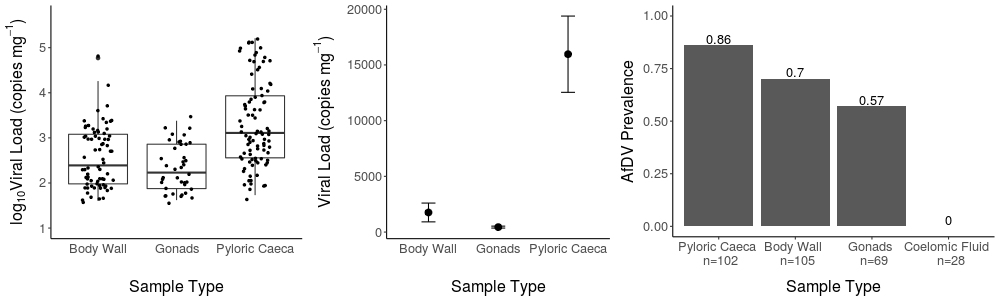

In [92]:
%%R -w 1000 -h 300

#p = p + geom_signif(comparisons = list(c("G","PC")),y_position = 5.4, annotations="***") + 
#                   geom_signif(comparisons = list(c("G","E")),y_position = 5,annotations="NA") + 
#                   geom_signif(comparisons = list(c("E","PC")),y_position = 5.7, annotations="***")

####Plot 1#####
p = ggplot(subset(qPCR, SampleType %in% c("G","PC","E")), aes(x = SampleType,y = Log))#,color=SampleType))

p = p + geom_boxplot() + geom_point(aes(y = Log), size = 1,
                   position = position_jitter(width = 0.2, height = 0.1))

#p = p + scale_color_manual(values = c("#ff6600","#ffff33","#33cc33"))

p = p + labs(y=expression(log[10]*"Viral Load (copies mg"^-1*")"))

p = p + theme_classic() + theme(text=element_text(size=16, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.ticks.x = element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)),
                           axis.title.x=element_text(margin=margin(27,0,0,0)))

p = p + scale_x_discrete(breaks=c("E", "G", "PC"), labels=c("Body Wall", "Gonads", "Pyloric Caeca"))

p = p + scale_y_continuous(limits=c(1, 5.7)) + xlab("Sample Type")

p

####Plot 2####
p2 = ggplot(qPCRsummary4, aes(x = SampleType,y = avg))

p2 = p2 + geom_point(aes(y = avg), size = 3, data = qPCRsummary4) + 
  geom_errorbar(aes(y = avg, ymin = avg-(1*sem), ymax = avg+(1*sem)), 
                color = "black", width = 0.2, data = qPCRsummary4)

#p2 = p2 + geom_signif(comparisons = list(c("G","PC")),y_position = 20500, annotations="***") + 
#                   geom_signif(comparisons = list(c("G","E")),y_position = 5000,annotations="NA") + 
#                   geom_signif(comparisons = list(c("E","PC")),y_position = 22000, annotations="***")

p2 = p2 + labs(y=expression("Viral Load (copies mg"^-1*")")) + xlab("Sample Type")

p2 = p2 + theme_classic() + theme(text=element_text(size=16, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.ticks.x = element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)),
                           axis.title.x=element_text(margin=margin(27,0,0,0)))

p2 = p2 + scale_x_discrete(breaks=c("E", "G", "PC"), labels=c("Body Wall", "Gonads", "Pyloric Caeca"))

p2

####Plot 3#####

p3 = ggplot(qPCRprev, aes(x= reorder(Tissue.Type,-Prevalence), y=Prevalence))
p3 = p3 + geom_bar(stat="identity")

p3 = p3 + scale_x_discrete(breaks=c("E", "G", "PC","CF"),
                         labels=c("Body Wall \n n=105", "Gonads \n n=69", 
                                  "Pyloric Caeca \n n=102","Coelomic Fluid \n n=28"))


p3 = p3 + ylab("AfDV Prevalence") + xlab("Sample Type") 

p3 = p3 + geom_text(aes(x=Tissue.Type, y=Prevalence, ymax=Prevalence,
                      label=Prevalence), vjust = -0.2, size=4.5) 

p3 = p3 + theme_classic() + theme(text=element_text(size=16, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.y=element_text(margin=margin(0,10,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p3 = p3 + scale_y_continuous(limits=c(0, 1))

p3 = p3 + scale_fill_manual(values = c("#ff6600","#ffff33","#33cc33"))

grid.arrange(nrow=1, p,p2,p3,widths=c(0.8,0.8,1))  ## switch theme_classic to theme_bw to get a border around graphs

In [91]:
%%R -w 800 -h 300

####Plot 2#####
p2 = ggplot(qPCR, aes(x = CollectionLocation,y = Log), color = factor(Species))

p2 = p2 + geom_boxplot() + geom_point(aes(y = Log, color = factor(Species)), size = 3, 
                   position = position_jitter(width = 0.2, height = 0.1))

p2 = p2 + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary2)# + 
  #geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
   #             color = "black", width = 0.2, data = qPCRsummary2)

p2 = p2 + xlab("Collection Location") + ylab(bquote('Log Viral Load (copies' ~ mg^-1~')'))

p2 = p2 + scale_x_discrete(breaks=c("MA", "SC", "SML"), labels=c("Massachusetts", "South Carolina", "Appledore Island"))

p2 = p2 + geom_signif(comparisons = list(c("MA","SC")),y_position = 5.4, annotations="***") + 
                   geom_signif(comparisons = list(c("SC","SML")),y_position = 5,annotations="**") + 
                   geom_signif(comparisons = list(c("SML","MA")),y_position = 5.7, annotations="***")

p2 = p2 + theme_classic() + theme(text=element_text(size=15, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           panel.border = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)))

p2 = p2 + scale_y_continuous(limits=c(1, 5.7))

p2

####Plot 3#####
p3 = ggplot(qPCR, aes(x = Species,y = Log), color = factor(Species))

p3 = p3 + geom_boxplot() + geom_point(aes(y = Log, color = factor(Species)), size = 3, 
                   position = position_jitter(width = 0.2, height = 0.1))

p3 = p3 + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary3)# +
    #geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
    #            color = "black", width = 0.2, data = qPCRsummary3)

p3 = p3 + geom_signif(comparisons = list(c("Asterias forbesi","Asterias vulgaris")),y_position = 5.4, annotations="**") + 
                   geom_signif(comparisons = list(c("Asterias forbesi","Henricia")),y_position = 5.7,annotations="NA") + 
                   geom_signif(comparisons = list(c("Asterias vulgaris","Henricia")),y_position = 4.8, annotations="*")

p3 = p3 + xlab("Species")

p3 = p3 + theme_classic() + theme(text=element_text(size=15, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           panel.border = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.title.y = element_blank(),
                           axis.title.x=element_text(margin=margin(10,0,0,0)))

p3 = p3 + scale_y_continuous(limits=c(1, 5.7))

p3

gridExtra::grid.arrange(nrow=1,p2,p3)


Error in fortify(data) : object 'qPCRsummary2' not found


/home/elliot/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in fortify(data) : object 'qPCRsummary2' not found

  warnings.warn(x, RRuntimeWarning)


In [567]:
%%R
qPCRsummaryyear = qPCR %>%
 group_by(CollectionYear) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

#limits = aes(ymax = quantity + sem, ymin=quantity - sem)

#p = ggplot(p, aes(Sample_Type,avg)) + geom_bar(stat="identity")# + geom_errorbar()

qPCRsummaryyear

# A tibble: 4 × 4
  CollectionYear      avg        sd        sem
           <int>    <dbl>     <dbl>      <dbl>
1           2016 2.998297 0.9139803 0.06774873
2           2012 2.430286 0.4820147 0.08147535
3             NA 1.780000        NA         NA
4           2013 1.680000        NA         NA


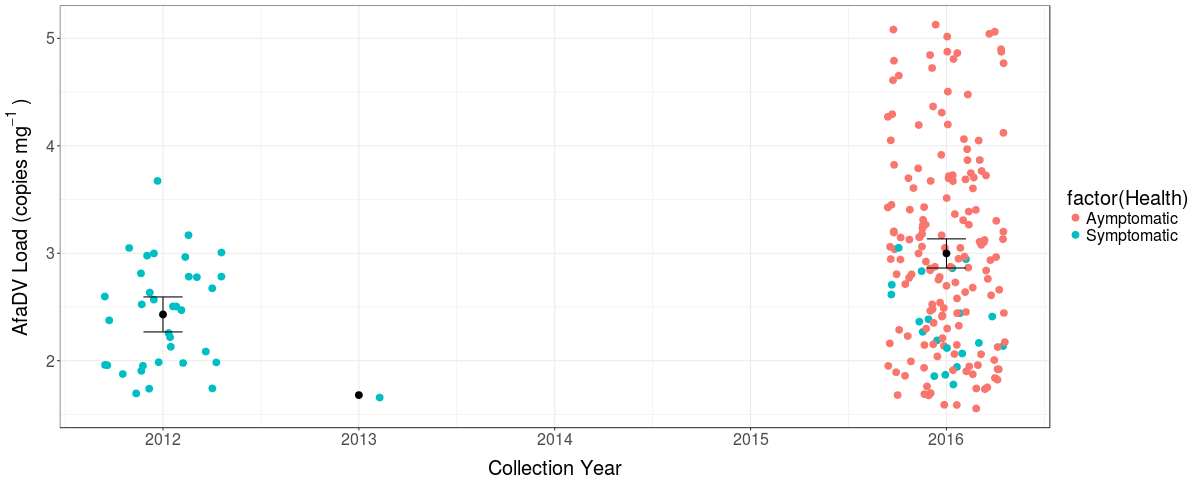

In [568]:
%%R -w 1200
####Plot 1#####
p = ggplot(qPCR, aes(x = CollectionYear,y = Log), color = factor(Health))

p = p + geom_point(aes(y = Log, color = factor(Health)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p = p + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummaryyear) + 
  geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = qPCRsummaryyear)

p = p + ylab(bquote('AfaDV Load (copies' ~ mg^-1~')')) + xlab("Collection Year")

p = p + theme_bw() + theme(text=element_text(size=20, color="black"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           #legend.position="none",
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p

In [497]:
%%R
qPCR.lm = lm(Log ~ AnimalSize, data = qPCR)
summary(qPCR.lm)
#coef(lm(Log ~ AnimalSize, data = qPCR))


Call:
lm(formula = Log ~ AnimalSize, data = qPCR)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.49435 -0.64379 -0.09012  0.44988  2.09585 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.87463    0.16820   23.04  < 2e-16 ***
AnimalSize  -0.13211    0.02456   -5.38 2.42e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8501 on 171 degrees of freedom
  (46 observations deleted due to missingness)
Multiple R-squared:  0.1448,	Adjusted R-squared:  0.1398 
F-statistic: 28.94 on 1 and 171 DF,  p-value: 2.423e-07



In [587]:
%%R
qPCR.pico = lm(Log ~ pico, data = qPCR)
summary(qPCR.pico)


Call:
lm(formula = Log ~ pico, data = qPCR)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50617 -0.69907 -0.07558  0.60306  1.93140 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.1126707  0.0932818  33.368   <2e-16 ***
pico        -0.0003890  0.0002164  -1.798   0.0749 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9086 on 113 degrees of freedom
  (104 observations deleted due to missingness)
Multiple R-squared:  0.02781,	Adjusted R-squared:  0.01921 
F-statistic: 3.232 on 1 and 113 DF,  p-value: 0.07487



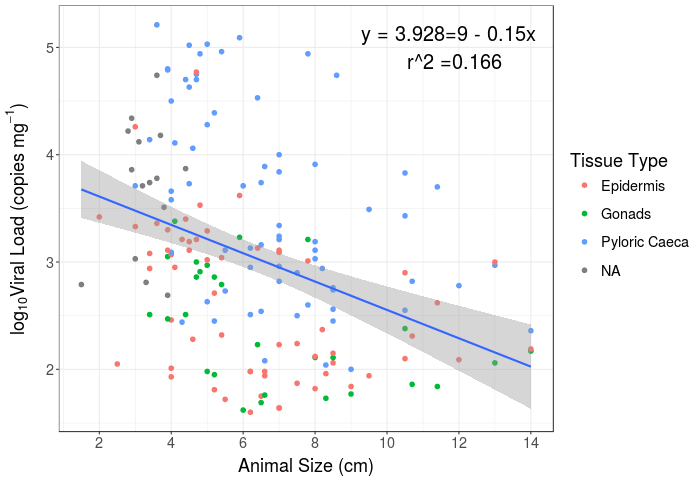

In [498]:
%%R -w 700

p = ggplot(qPCR, aes(x=AnimalSize, y=Log)) + geom_point(aes(colour = factor(SampleType)), size = 2)

p = p + geom_smooth(method=lm)

p = p + scale_x_continuous(breaks = c(2,4,6,8,10,12,14,16)) 

p = p + scale_color_discrete(name="Tissue Type",labels=c("Epidermis","Gonads","Pyloric Caeca"))

p = p + theme_bw() + theme(legend.key = element_blank(),
                           text=element_text(size=18),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)),
                           legend.key.size = unit(1, "cm"))

p = p + labs(y=expression(log[10]*"Viral Load (copies mg"^-1*")"))

p = p + xlab("Animal Size (cm)")

p = p + annotate("text", label = "y = 3.928=9 - 0.15x \n r^2 =0.166", x = 11.8, y = 5, size = 7, colour = "black")

p

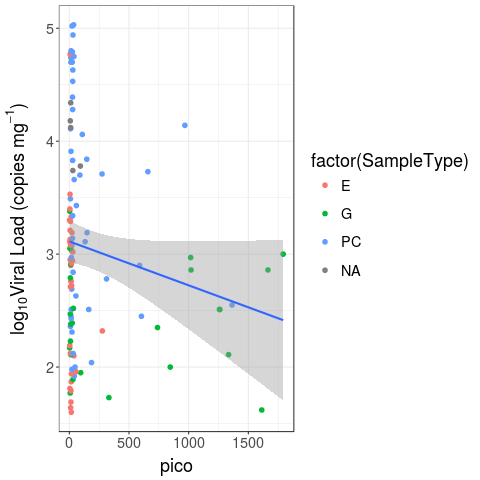

In [596]:
%%R


p = ggplot(qPCR[which(qPCR$pico<=2000),],aes(x=pico, y=Log)) + geom_point(aes(colour = factor(SampleType)), size = 2)

p = p + geom_smooth(method=lm)

#p = p + scale_x_continuous(breaks = c(2,4,6,8,10,12,14,16)) 


p = p + theme_bw() + theme(legend.key = element_blank(),
                           text=element_text(size=18),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)),
                           legend.key.size = unit(1, "cm"))

p = p + labs(y=expression(log[10]*"Viral Load (copies mg"^-1*")"))

#p = p + xlab("Animal Size (cm)")

p

## Genome Coverage

In [298]:
%%R
basecov = read.table("data/bascov-Copy1.txt")
basecov = tbl_df(basecov)
glimpse(basecov)

Observations: 6,089
Variables: 3
$ V1 <fctr> NODE_1_length_6089_cov_35.966, NODE_1_length_6089_cov_35.966, N...
$ V2 <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18...
$ V3 <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 1...


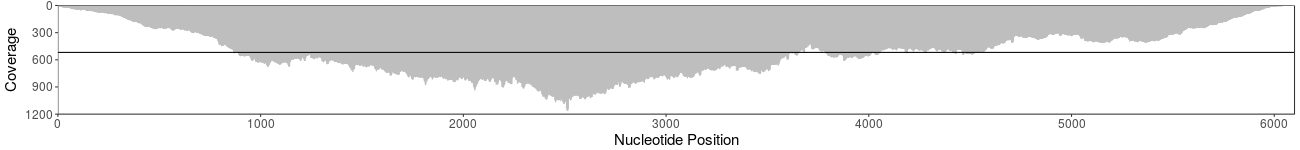

In [345]:
%%R -h 150 -w 1300
p = ggplot(basecov,aes(x=V2, y=V3))

p = p + geom_bar(fill = "black",stat="identity", colour="grey")

p = p + ylab("Coverage") + xlab("Nucleotide Position")

p = p + geom_hline(yintercept = 518.5) + scale_y_reverse() 

p = p + theme_bw() + theme(text=element_text(size=15, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")

p = p + scale_x_continuous(limits = c(0,6100), breaks=c(0,1000,2000,3000,4000,5000,6000), expand = c(0, 0))

p = p + scale_y_continuous(trans = 'reverse',limits = c(1200,0), expand = c(0, 0))

p